In [23]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as signal
import pandas as pd

import obspy
import obspy.signal.trigger as trigger
from obspy import taup, geodetics

from osgeo import gdal, ogr

import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

## setting client
from obspy.clients.fdsn import Client
client = Client("IRIS")

## Getting all events

In [3]:
## retrieveing events within an area\n",
starttime = obspy.UTCDateTime("2020-09-01T00:00:00")
endtime = obspy.UTCDateTime("2020-09-10T00:00:00")

cat0 = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=0, 
                         latitude=63.98,longitude=-143.99, maxradius=4)
cat1 = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=1, 
                         latitude=63.98,longitude=-143.99, minradius = 4, maxradius=8)
cat2 = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=2, 
                         latitude=63.98,longitude=-143.99, minradius = 8, maxradius=20)
cat3 = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=3, 
                         latitude=63.98,longitude=-143.99, minradius = 20, maxradius=100)
cat4 = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=4, 
                         latitude=63.98,longitude=-143.99, minradius = 100, maxradius=180)
cat_all = cat1 + cat2 + cat3 + cat4 + cat0

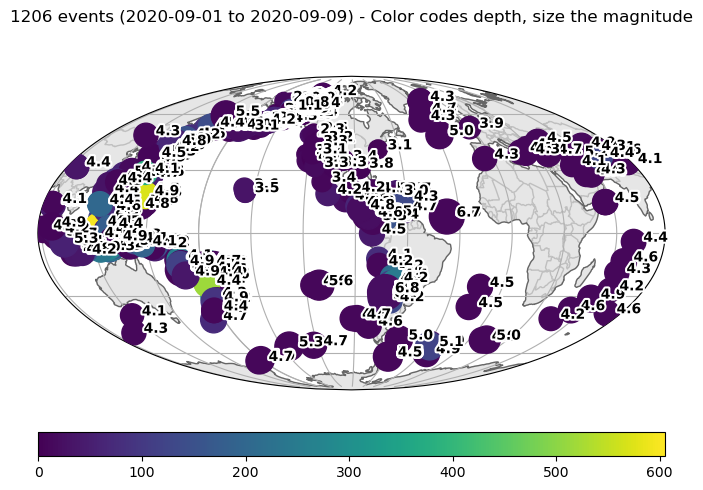

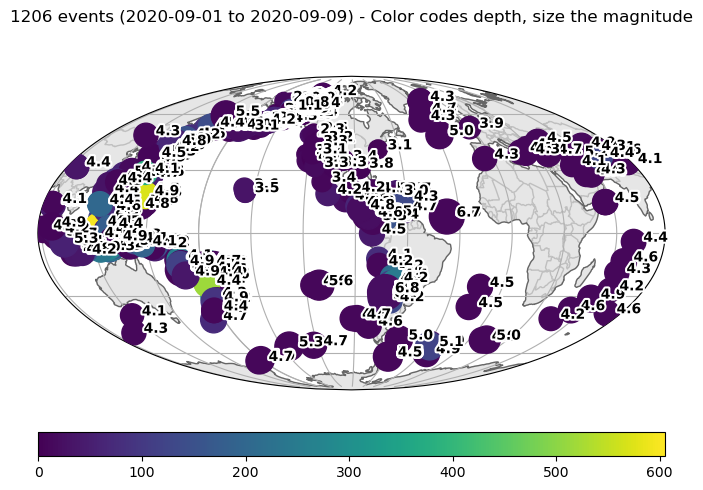

In [4]:
# cattest = client.get_events(starttime=starttime, endtime="2021-09-10T00:00:00", minmagnitude=7, 
#                          latitude=63.98,longitude=-143.99, minradius = 0, maxradius=180)
# cattest.plot()
cat_all.plot()

In [5]:
## getting 10 day data from SCRK station\n",
## get SCRK station
inventory = client.get_stations(network="AK", station="SCRK")
SCRK_station = inventory[0].stations[0]

SCRK_stream = client.get_waveforms("AK", "SCRK", "*", "BHZ", starttime=starttime, endtime=endtime)
st = SCRK_stream.merge(method=0,fill_value=0).detrend().filter("bandpass", freqmin=0.5, freqmax=24)
#st.plot()

### Picking using STA/LTA

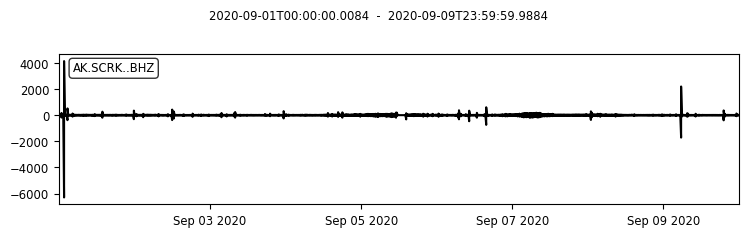

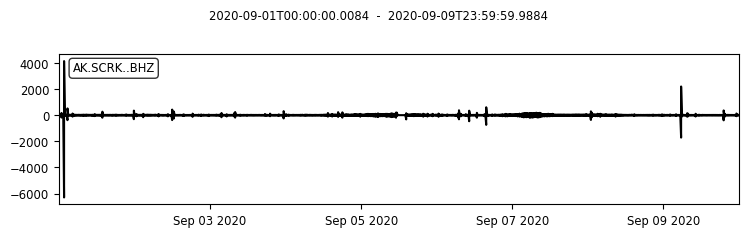

In [11]:
trace = st[0]
trace_times = trace.times()
# trace_times = trace.stats.starttime + trace_times                 ## don't use for large datasets

fs = trace.stats.sampling_rate
cft = trigger.recursive_sta_lta(trace.data, int(5 * fs), int(10 * fs))
# trigger.plot_trigger(trace, cft, 1.2, 0.5)

## defione threshold above which to trigger (value from Tian et al.)
cft_threshold = 1.35

## define time offsets from theoretical arrival time within which to check for peak (value from Tian eta l.)
minsample_offset = int(10/trace.stats.delta)     ## search starting 10 s before
maxsample_offset = int(30/trace.stats.delta)     ## search till 30 s after

st.plot()

### Empty lists and datafram for catalog to dataframe conversion

In [7]:
sourcetime = []
arrivaltime = []
lat = []
lon = []
dep = []
magnitude = []
magnitude_type = []
event_type = []

In [8]:
## intitalize a model using taup
model = taup.TauPyModel(model="prem")

cat_select = []

for event in cat_all:
    if len(event.origins) != 0 and len(event.magnitudes) != 0:
        station_event_dist_deg = geodetics.base.kilometers2degrees(geodetics.locations2degrees(event.origins[0].latitude, event.origins[0].longitude, SCRK_station.latitude, SCRK_station.longitude))
        model = obspy.taup.TauPyModel(model="prem")
        travel_time = model.get_travel_times(source_depth_in_km=max(0.0, event.origins[0].depth*1e-3), distance_in_degree=station_event_dist_deg)
        arrival_time_utc = event.origins[0].time + travel_time[0].time 
        arrival_time_relative = arrival_time_utc - trace.stats.starttime

        closest_stream_sample = np.absolute(trace_times-arrival_time_relative).argmin()
        search_range = range(closest_stream_sample - minsample_offset, closest_stream_sample + maxsample_offset)
        if np.max(cft[search_range]) >= cft_threshold:
            sourcetime.append(event.origins[0].time)
            lat.append(event.origins[0].latitude)  
            lon.append(event.origins[0].longitude)
            dep.append(event.origins[0].depth)
            magnitude.append(event.magnitudes[0].mag)
            magnitude_type.append(event.magnitudes[0].magnitude_type )
            event_type.append(event.event_type)
            arrivaltime.append(arrival_time_utc)

In [157]:
catalog_df = pd.DataFrame({'Latitude':lat,'Longitude':lon,'Depth':dep,
                    'Magnitude':magnitude,'Magnitude_type':magnitude_type, 
                    'Event_type': event_type, 'SourceTime': sourcetime, 'SCRKarrivaltime': arrivaltime})
catalog_df.to_csv("SCRK_events.csv")

array([[<AxesSubplot:title={'center':'Magnitude'}>]], dtype=object)

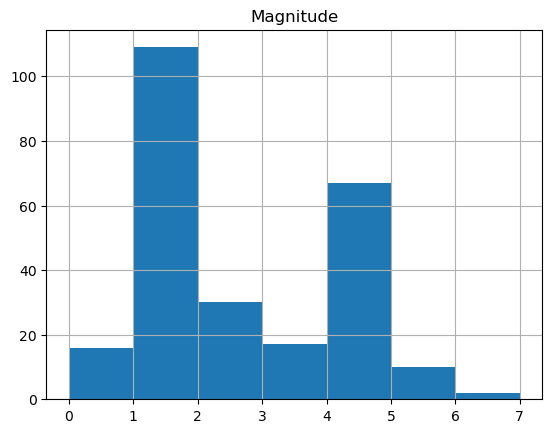

In [158]:
catalog_df.hist(column="Magnitude", bins = [0,1,2,3,4,5,6,7])

array([[<AxesSubplot:title={'center':'Magnitude'}>]], dtype=object)

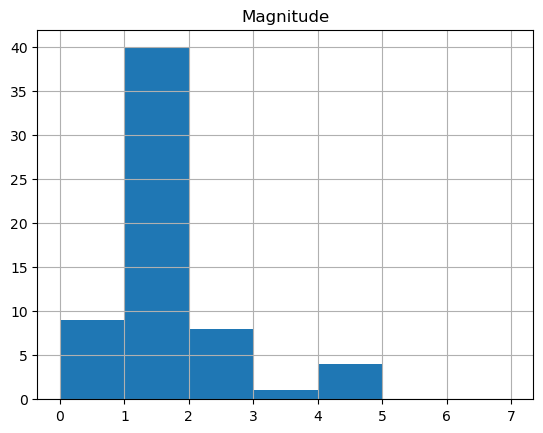

In [159]:
## intraplate events decided based on a specific distance (500 km) from plate boundaries using ArcMap
intraplate_catalog_df = pd.read_csv("SCRK_events_intraplate.csv")
intraplate_catalog_df.hist(column="Magnitude", bins = [0,1,2,3,4,5,6,7])

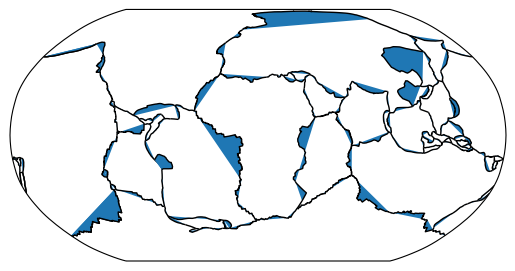

In [32]:
bufferDist = 20

infile = "plate_boundaries/PB2002_boundaries.shp"
# outbuffer = "plate_boundaries/buffer_PB2002_boundaries.shp"

# inds = ogr.Open(infile)
# inlyr = inds.GetLayer()

# shpdriver = ogr.GetDriverByName('ESRI Shapefile')
# if os.path.exists(outbuffer):
#     shpdriver.DeleteDataSource(outbuffer)
# outputBufferds = shpdriver.CreateDataSource(outbuffer)
# bufferlyr = outputBufferds.CreateLayer(outbuffer, geom_type=ogr.wkbPolygon)
# featureDefn = bufferlyr.GetLayerDefn()

    
# for feature in inlyr:
#     ingeom = feature.GetGeometryRef()
#     geomBuffer = ingeom.Buffer(bufferDist)
    
#     outFeature = ogr.Feature(featureDefn)
#     outFeature.SetGeometry(geomBuffer)
#     bufferlyr.CreateFeature(outFeature)
#     outFeature = None
    
ax = plt.axes(projection=ccrs.Robinson())
shape_feature = ShapelyFeature(Reader(infile).geometries(),
                                ccrs.PlateCarree(), edgecolor='black')
ax.add_feature(shape_feature)
plt.show()

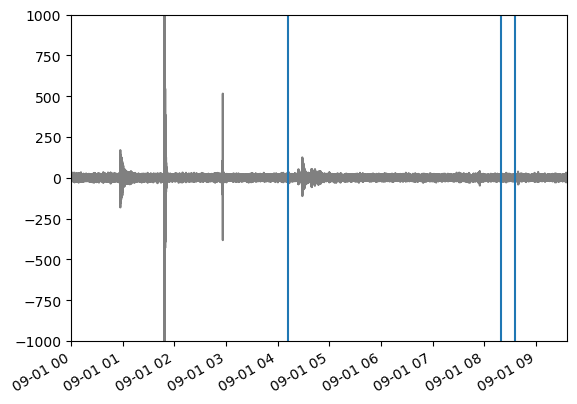

In [182]:
arr_time = np.array(intraplate_catalog_df.SCRKarrivaltime)
tr = st[0]
fig, ax = plt.subplots(1, 1)
ax.plot(tr.times("matplotlib"), tr.data, "grey")
ax.xaxis_date()
ax.vlines(arr_time, ymin = -1000, ymax = 1000)
ax.set_xlim(18506, 18506.4)
ax.set_ylim(-1000, 1000)
fig.autofmt_xdate()
plt.show()

In [163]:
pd.set_option('display.max_rows', None)
shallow_catalog_df = intraplate_catalog_df.loc[(intraplate_catalog_df.Depth < 100e3) & (intraplate_catalog_df.Depth > 0)]
print(shallow_catalog_df.shape)
# print(intraplate_catalog_df.loc[(intraplate_catalog_df.Latitude > 60.0) & (intraplate_catalog_df.Magnitude > 2.0)])

(51, 10)


## Spectrograms

In [90]:
tr_trunc = tr.slice(starttime = obspy.UTCDateTime("2020-09-01T08:35:47.808937Z")-20, endtime =  obspy.UTCDateTime("2020-09-01T08:35:47.808937Z")+120)
tr_trunc1 = tr.slice(starttime = obspy.UTCDateTime("2020-09-06T12:34:58.719000Z")+600, endtime =  obspy.UTCDateTime("2020-09-06T12:34:58.719000Z")+1200)

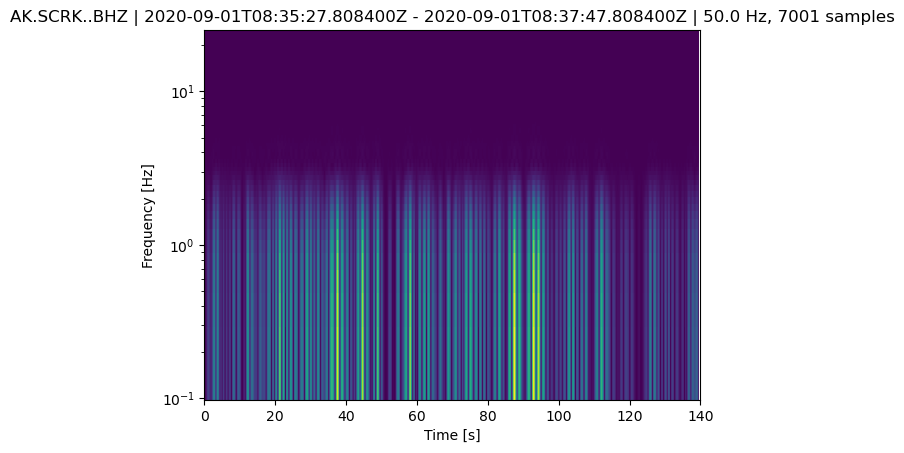

In [64]:
tr_filt = tr_trunc.copy()
tr_filt.filter('lowpass', freq=0.5)
tr_filt.spectrogram(log=True)

## Fourier transforms

In [65]:
data = tr_trunc.data
DATA = np.fft.fftshift(np.fft.fft(data, len(data)))
freq = np.fft.fftshift(np.fft.fftfreq(len(data), tr_trunc.stats.delta))

In [66]:
data1 = tr_filt.data
DATA1 = np.fft.fftshift(np.fft.fft(data1, len(data1)))
freq1 = np.fft.fftshift(np.fft.fftfreq(len(data1), tr_filt.stats.delta))

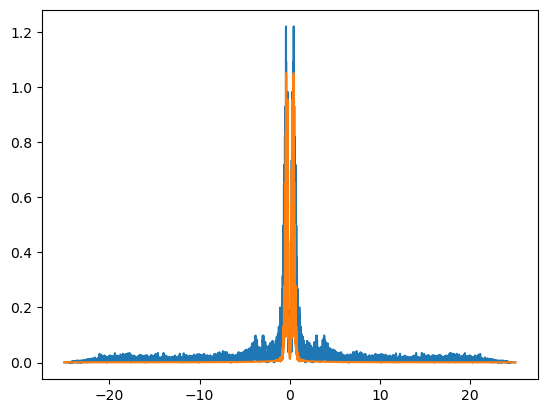

In [69]:
fig, ax = plt.subplots(1,1)
ax.plot(freq, np.abs(DATA)/len(data))
ax.plot(freq1, np.abs(DATA1)/len(data))
plt.show()

## Periodograms

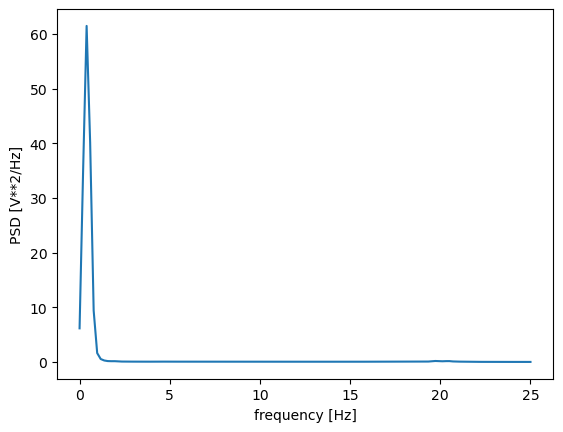

In [177]:
f_floor, PSD_floor =  signal.welch(tr_trunc1.data, fs = 1/tr_trunc.stats.delta)
plt.plot(f_floor, PSD_floor)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

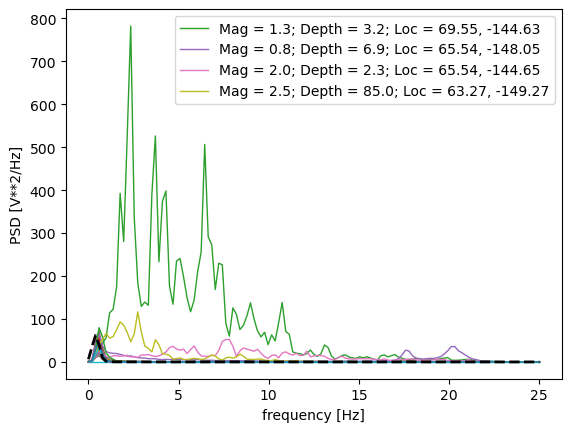

In [174]:
fig, ax = plt.subplots(1,1)

for arrtime in shallow_catalog_df.SCRKarrivaltime:
    event = shallow_catalog_df.loc[(shallow_catalog_df.SCRKarrivaltime == arrtime)]
    mag = event.loc[event.index[0]]["Magnitude"]
    dep = round(event.loc[event.index[0]]["Depth"]/1000, 2)
    lat = round(event.loc[event.index[0]]["Latitude"], 2)
    lon = round(event.loc[event.index[0]]["Longitude"], 2)
    tr_trunc = tr.slice(starttime = obspy.UTCDateTime(arrtime)-80, endtime =  obspy.UTCDateTime(arrtime)+600).filter('highpass', freq=0.5)
    f, PSD =  signal.welch(tr_trunc.data, fs = 1/tr_trunc.stats.delta)
    if np.mean(PSD[5:-1]) > 1:
        ax.plot(f, PSD, linewidth = "1", label = "Mag = "+str(mag)+"; Depth = "+str(dep)+"; Loc = "+str(lat)+", "+str(lon))
    else:
        ax.plot(f, PSD, linewidth = "1")
    
ax.plot(f_floor, PSD_floor, "k", linestyle = "--", linewidth = "2")
# plt.xlim(-1,7)
plt.legend()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()